# Error Analysis

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import re
import seaborn as sns
from evaluate import load  # https://huggingface.co/evaluate-metric
from IPython.display import display

2024-06-10 12:50:17.630985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 12:50:17.679632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 12:50:17.679678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 12:50:17.680996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 12:50:17.689603: I tensorflow/core/platform/cpu_feature_guar

In [3]:
FIGS_DIR = Path('../figures/')
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
})

## Results Slicing

In [4]:
PLMs = {
    "codet5-base-multi-sum": "codet5-base",
    "codet5p_220m_py_sum": "codet5p-base",
    "pile-t5-large-codexglue": "pile-t5-large",
    "code_trans_t5_large_code_documentation_generation_python_multitask_finetune": "ct-t5-large-doc",
    "code_trans_t5_large_source_code_summarization_python_multitask_finetune": "ct-t5-large-sum",
}

LLMs = {
    "deepseek-coder-1.3b-instruct": "deepseek-coder-1.3b",
    "deepseek-coder-6.7b-instruct": "deepseek-coder-6.7b",
    "deepseek-coder-33b-instruct": "deepseek-coder-33b",
    "starcoder2-15b-instruct-v0.1": "starcoder2-15b",
    "Llama-3-8B-Instruct-Gradient-1048k": "llama3-8b",
}

MODEL_TO_SHORT_NAME = dict(list(PLMs.items()) + list(LLMs.items()))

NAME_COLUMNS = ['Model', 'Subset', 'Few-shot', 'Context']
MAX_METRICS_SUBSET = [
    "BLEURT",
    "BERTScore$_{F1}$",
    "ROUGE$_{L}$",
    "METEOR",
    "BLEU$_{4}$",
]
MIN_METRICS_SUBSET = ["SIDE"]

PERCENT_METRICS = ["ROUGE$_{L}$", "METEOR", "BLEU$_{4}$"]
SCORE_METRICS = ["SIDE", "BLEURT", "BERTScore$_{F1}$", "SIDE_true"]

SORT_BY = "SIDE"
SORT_ASCENDING = True


def contains_all(df, patterns, exclude=None):
    mask = pd.Series(True, index=df.index)
    for pattern in patterns:
        mask &= df.Model.str.contains(pattern)
    if exclude:
        for pattern in exclude:
            mask &= ~df.Model.str.contains(pattern)
    return mask


def preprocess_name(row):
    model, subset, few_shot, context = None, None, 0, None
    name = row['Name']
    if "mce" in name:
        model, name = name.split('/')
        context = name.split('-')[0]
        context = None if context == 'method' else context
        if "few-shot" in name:
            few_shot = int(name.split('-')[5])
    elif "mcsn" in name:
        if "total" in name:
            model, name, subset = name.split('/')
        else:
            model, name, repo, project = name.split('/')
            subset = repo + '/' + project
        if "few-shot" in name:
            few_shot = int(name.split('-')[5])
        if "context" in name:
            context = name.split('-')[7] + ' chunks'
    model = MODEL_TO_SHORT_NAME[model]
    few_shot = int(few_shot)
    return model, subset, few_shot, context

def preprocess_columns(df):
    df = df.reindex(columns=NAME_COLUMNS + ['SIDE_pred', 'BLEURT', 'BERTScore', 'ROUGE-L', 'METEOR', 'BLEU-4', 'SIDE_true'])
    df.rename(columns={"SIDE_pred": "SIDE"}, inplace=True)
    df.rename(columns={"BERTScore": "BERTScore" + r"$_{F1}$"}, inplace=True)
    df.rename(columns={"BLEU-4": "BLEU" + r"$_{4}$"}, inplace=True)
    df.rename(columns={"ROUGE-L": "ROUGE" + r"$_{L}$"}, inplace=True)
    return df

def round_metrics(row):
    for metric in SCORE_METRICS:
        row[metric] = round(row[metric], 3)
    for metric in PERCENT_METRICS:
        row[metric] = round(row[metric] * 100, 2)
    return row

In [5]:
results_path = Path('../data/predicted/results.csv')
results_df = pd.read_csv(results_path)

results_df[NAME_COLUMNS] = results_df.apply(lambda x: preprocess_name(x), axis=1, result_type='expand')
results_df = preprocess_columns(results_df)

display(results_df)

Model                      Subset  Few-shot Context      SIDE  \
0    codet5p-base                        None         0    None  0.239890   
1    codet5p-base                       total         0    None  0.074515   
2    codet5p-base              apache/airflow         0    None  0.044657   
3    codet5p-base  Azure/azure-sdk-for-python         0    None  0.119678   
4    codet5p-base       streamlink/streamlink         0    None  0.084064   
..            ...                         ...       ...     ...       ...   
590   codet5-base                       total         0    None  0.067139   
591   codet5-base              apache/airflow         0    None  0.034271   
592   codet5-base  Azure/azure-sdk-for-python         0    None  0.115884   
593   codet5-base       streamlink/streamlink         0    None  0.068315   
594   codet5-base             open-mmlab/mmcv         0    None  0.097840   

       BLEURT  BERTScore$_{F1}$  ROUGE$_{L}$    METEOR  BLEU$_{4}$  SIDE_true  
0    0.534413          0.726391     0.414291  0.353755    0.085496   0.476460  
1    0.501865          0.720890     0.356795  0.336284    0.042986   0.174523  
2    0.490943          0.710246     0.352340  0.320065    0.036900   0.194110  
3    0.509270          0.736520     0.353655  0.342575    0.037123   0.128168  
4    0.481218          0.695686     0.287939  0.285274    0.020087   0.203580  
..        ...               ...          ...       ...         ...        ...  
590  0.483341          0.706016     0.334047  0.323887    0.029821   0.174523  
591  0.470333          0.694867     0.329200  0.308856    0.029811   0.194110  
592  0.506550          0.728445     0.347850  0.344370    0.023007   0.128168  
593  0.456134          0.687066     0.280251  0.265929    0.012621   0.203580  
594  0.513487          0.716023     0.377909  0.417516    0.079161   0.190771  

[595 rows x 11 columns]

In [6]:
def to_latex(df, label="", caption=""):
    # Check for values in columns
    few_shots = df["Few-shot"].unique()
    contexts = df["Context"].unique()
    subsets = df["Subset"].unique()
    if len(few_shots) == 1 and few_shots[0] == 0:
        df = df.drop(['Few-shot'], axis=1)
    if df['Context'].isnull().all():
        df = df.drop(['Context'], axis=1)
    if len(subsets) == 1:
        df = df.drop(['Subset'], axis=1)
    multirow_array = None
    if len(few_shots) > 1 or len(contexts) > 1 or len(subsets) > 1:
        multirow_array = few_shots if len(few_shots) > 1 else contexts if len(contexts) > 1 else subsets

    # Round all metrics
    df = df.apply(round_metrics, axis=1)

    # Separate SIDE_true to footnotes and drop it from table
    SIDE_true = df["SIDE_true"].iloc[0]
    df = df.drop(['SIDE_true'], axis=1)

    # Highlight best metrics
    for col in MAX_METRICS_SUBSET:
        if col in PERCENT_METRICS:
            df[col] = df[col].apply(
                lambda x: r"\underline{\textbf{" + f"{x:.2f}" + "}}" if x == df[col].max() else f"{x:.2f}"
            )
        elif col in SCORE_METRICS:
            df[col] = df[col].apply(
                lambda x: r"\underline{\textbf{" + f"{x:.3f}" + "}}" if x == df[col].max() else f"{x:.3f}"
            )
    for col in MIN_METRICS_SUBSET:
        df[col] = df[col].apply(  # SCORE_METRICS
            lambda x: r"\underline{\textbf{" + f"{x:.3f}" + "}}" if x == df[col].min() else f"{x:.3f}"
        )
    
    # Style column names
    df.rename(columns={"SIDE": "SIDE" + r"\tnote{1}"}, inplace=True)
    df.columns = [r"\textbf{" + col + "}" for col in df.columns]

    # Transform DF to latex
    latex = df.to_latex(index=False).rstrip()

    # Change columns alignment
    columns = len(df.columns)
    latex = re.sub("l" * columns, "l" + "c" * (columns - 1), latex)
    latex = re.sub("lr" + "l" * (columns - 2), "l" + "c" * (columns - 1), latex)

    # Add multicolomns and rules if few_shot
    if multirow_array is not None:
        # Extract table body between \midrule and \bottomrule
        body = re.search(r"\\midrule(.*?)\\bottomrule", latex, re.DOTALL).group(1)
        new_body = ""
        # Split body into rows
        rows = body.split(r"\\")
        rows = [row.strip() for row in rows if len(row.strip()) > 0]
        for i, row in enumerate(rows):
            model_name = row.split("&")[0]
            if i % len(multirow_array) == 0:
                if i != 0:
                    new_body += r"\midrule" + "\n"
                new_body += (
                    row.replace(
                        model_name,
                        r"\multirow{"
                        + str(len(multirow_array))
                        + r"}{*}{"
                        + model_name.strip()
                        + r"} ",
                    )
                    + r"\\" + "\n"
                )
            else:
                new_body += row.replace(model_name, "") + r"\\" + "\n"
        latex = latex.replace(body, new_body)

    # Print latex string
    prefix = (
        r"\begin{table}[h]"
        + "\n"
        + r"\centering\captionsetup{justification=centering}"
        + "\n"
        + r"\caption{"
        + caption
        + "}\n"
        + r"\label{tab:"
        + label
        + "}\n"
        + r"\begin{threeparttable}[b]"
        + "\n"
        + r"\resizebox{\textwidth}{!}{"
        + "\n"
    )
    suffix = (
        "}\n"
        + r"\begin{tablenotes}"
        + "\n"
        + r"\footnotesize \item[1] "
        + f"Ground truth value of SIDE is {SIDE_true}.\n"
        + r"\end{tablenotes}"
        + "\n"
        + r"\end{threeparttable}"
        + "\n"
        + r"\end{table}"
    )
    print(prefix + latex + suffix)

## MCE

In [129]:
# All results for MCE (Func-level)
tdf = results_df[(results_df['Few-shot'] == 0) & (results_df['Context'].isnull()) & (results_df['Subset'].isnull())].sort_values(by=SORT_BY, ascending=SORT_ASCENDING)
display(
    tdf.style.highlight_max(
        color="lightgreen", subset=MAX_METRICS_SUBSET
    ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
)
to_latex(tdf, label="results-func-lvl-mce", caption="Function-level Code Summarization Results on Modified ClassEval")

\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Function-level Code Summarization Results on Modified ClassEval}
\label{tab:results-func-lvl-mce}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
\textbf{Model} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule
codet5-base & \underline{\textbf{0.203}} & 0.498 & 0.699 & 36.81 & 31.97 & 5.66 \\
pile-t5-large & 0.234 & 0.524 & 0.716 & 39.38 & 33.39 & 6.53 \\
codet5p-base & 0.240 & 0.534 & \underline{\textbf{0.726}} & \underline{\textbf{41.43}} & 35.38 & \underline{\textbf{8.55}} \\
ct-t5-large-doc & 0.290 & 0.511 & 0.694 & 37.31 & 30.80 & 4.81 \\
ct-t5-large-sum & 0.334 & 0.435 & 0.643 & 27.06 & 20.73 & 2.24 \\
deepseek-coder-1.3b & 0.719 & \underline{\textbf{0.549}} & 0.640 & 26.04 & \underline{\textbf{36.57}} & 3.83 \\
starcoder2-15b & 0.915 & 0.518 & 0.559 & 17.69 & 29.84 & 2.33 

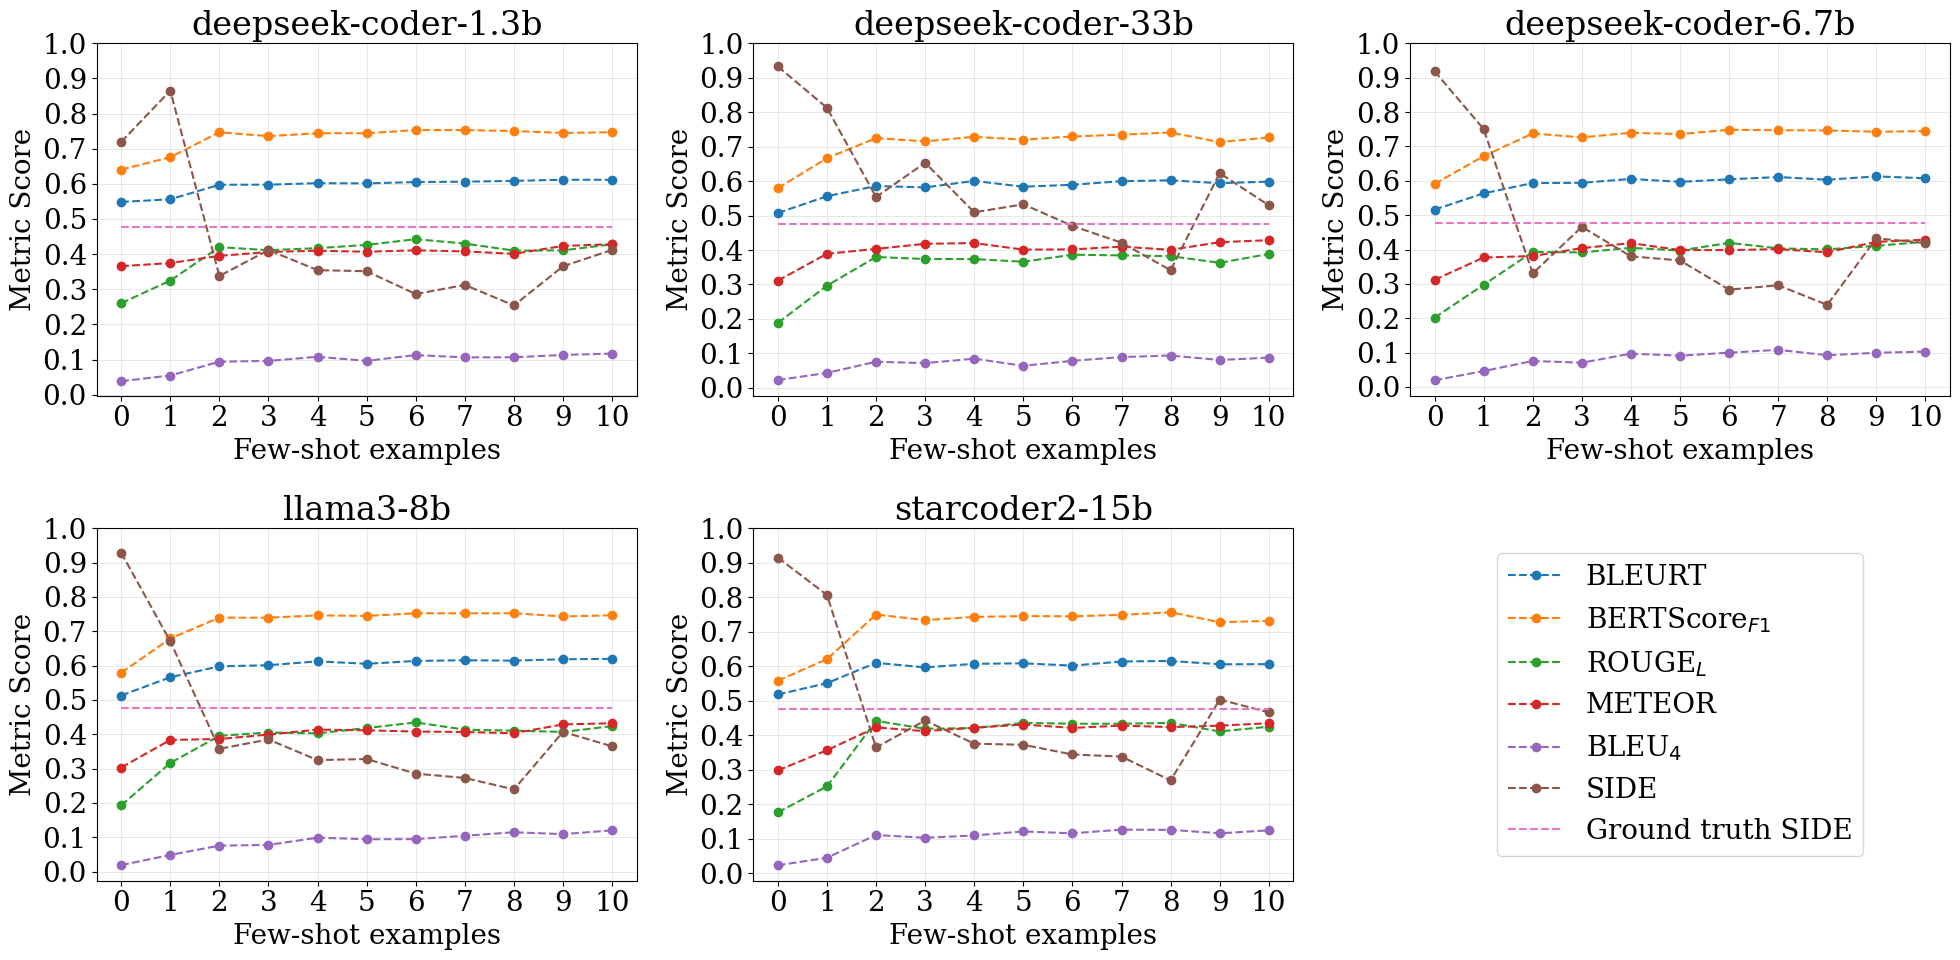

In [10]:
# All results for MCE (Func-level with few-shot)
tdf = results_df[(results_df['Model'].isin(LLMs.values())) & (results_df['Context'].isnull()) & (results_df['Subset'].isnull())].sort_values(by=['Model', 'Few-shot', SORT_BY], ascending=[True, True, True])

metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET
grouped = tdf.groupby('Model')
num_models = len(grouped)
num_cols = 3
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
axs = axs.flatten() if num_rows > 1 else [axs]
legend_elements = []
for i, (model, group) in enumerate(grouped):
    group = group.sort_values(by='Few-shot')
    ax = axs[i]
    for j, metric in enumerate(metrics):
        plot = ax.plot(group['Few-shot'], group[metric], linestyle='--', marker='o')
        if i == num_models - 1:
            legend_elements.append(mlines.Line2D([0], [0], marker='o', color=plot[0].get_color(), linestyle='--', label=metric))
    plot = ax.plot(group['Few-shot'], group['SIDE_true'], label='Ground truth SIDE', linestyle='--')
    if i == num_models - 1:
        legend_elements.append(mlines.Line2D([0], [0], color=plot[0].get_color(), linestyle='--', label='Ground truth SIDE'))
    ax.set_xlabel('Few-shot examples')
    ax.set_ylabel('Metric Score')
    ax.set_xticks(range(0, 11, 1))
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_title(model)
    ax.grid(True, color='gray', linewidth=0.5, alpha=0.25)
    

for i in range(num_models, num_rows * num_cols):
    axs[i].axis('off')
    axs[i].legend(handles=legend_elements, loc='center')
plt.tight_layout()
plt.show()

In [130]:
# All results for MCE (Func-level with few-shot)
tdf = results_df[(results_df['Model'].isin(LLMs.values())) & (results_df['Context'].isnull()) & (results_df['Subset'].isnull())].sort_values(by=['Model', 'Few-shot', SORT_BY], ascending=[True, True, True])

metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET
grouped = tdf.groupby('Model')
num_models = len(grouped)
num_cols = 2
num_rows = num_models // num_cols + num_models % num_cols  # Integer division, rounding up
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))
axs = axs.flatten() if num_rows > 1 else [axs]
legend_elements = []
for i, (model, group) in enumerate(grouped):
    group = group.sort_values(by='Few-shot')
    ax = axs[i]
    for j, metric in enumerate(metrics):
        plot = ax.plot(group['Few-shot'], group[metric], linestyle='--', marker='o')
        if i == num_models - 1:
            legend_elements.append(mlines.Line2D([0], [0], marker='o', color=plot[0].get_color(), linestyle='--', label=metric))
    plot = ax.plot(group['Few-shot'], group['SIDE_true'], label='Ground truth SIDE', linestyle='--')
    if i == num_models - 1:
        legend_elements.append(mlines.Line2D([0], [0], color=plot[0].get_color(), linestyle='--', label='Ground truth SIDE'))
    ax.set_xlabel('Few-shot examples')
    ax.set_ylabel('Metric Score')
    ax.set_xticks(range(0, 11, 1))
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_title(model)
    ax.grid(True, color='gray', linewidth=0.5, alpha=0.5)
    

for i in range(num_models, num_rows * num_cols):
    axs[i].axis('off')
    axs[i].legend(handles=legend_elements, loc='center')
plt.tight_layout()
plt.show()

tdf = tdf[tdf['Few-shot'].isin([0, 2, 8, 10])]
# display(
#     tdf.style.highlight_max(
#         color="lightgreen", subset=MAX_METRICS_SUBSET
#     ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
# )
to_latex(tdf, label="results-func-lvl-mce-few-shot", caption="Function-level with few-shot Code Summarization Results on Modified ClassEval")

\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Function-level with few-shot Code Summarization Results on Modified ClassEval}
\label{tab:results-func-lvl-mce-few-shot}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lccccccc}
\toprule
\textbf{Model} & \textbf{Few-shot} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule\multirow{4}{*}{deepseek-coder-1.3b} & 0 & 0.719 & 0.549 & 0.640 & 26.04 & 36.57 & 3.83\\
& 2 & 0.338 & 0.598 & 0.747 & 41.99 & 39.51 & 9.39\\
& 8 & 0.254 & 0.608 & 0.750 & 41.00 & 40.09 & 10.64\\
& 10 & 0.412 & 0.611 & 0.747 & 42.80 & 42.82 & 11.69\\
\midrule
\multirow{4}{*}{deepseek-coder-33b} & 0 & 0.933 & 0.507 & 0.579 & 18.84 & 31.09 & 2.25\\
& 2 & 0.554 & 0.586 & 0.725 & 37.98 & 40.32 & 7.55\\
& 8 & 0.341 & 0.602 & 0.741 & 38.21 & 40.06 & 9.36\\
& 10 & 0.530 & 0.599 & 0.727 & 38.85 & 42.85 & 8.76\\
\midrule
\multirow{4}{*}{d

In [131]:
# All results for MCE (Class-level)
tdf = results_df[results_df['Context'].isin(['skeleton', 'class'])].sort_values(by=['Model', 'Context'], ascending=[True, True])
display(
    tdf.style.highlight_max(
        color="lightgreen", subset=MAX_METRICS_SUBSET
    ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
)
to_latex(
    tdf,
    label="results-class-lvl-mce",
    caption="Class-level Code Summarization Results on Modified ClassEval",
)

\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Class-level Code Summarization Results on Modified ClassEval}
\label{tab:results-class-lvl-mce}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lccccccc}
\toprule
\textbf{Model} & \textbf{Context} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule\multirow{2}{*}{deepseek-coder-1.3b} & class & 0.693 & 0.576 & 0.684 & \underline{\textbf{36.85}} & 46.82 & 9.02\\
& skeleton & \underline{\textbf{0.676}} & \underline{\textbf{0.586}} & \underline{\textbf{0.691}} & 36.74 & \underline{\textbf{47.87}} & \underline{\textbf{10.50}}\\
\midrule
\multirow{2}{*}{deepseek-coder-33b} & class & 0.929 & 0.532 & 0.606 & 24.17 & 38.46 & 4.47\\
& skeleton & 0.934 & 0.536 & 0.605 & 24.34 & 38.31 & 5.10\\
\midrule
\multirow{2}{*}{deepseek-coder-6.7b} & class & 0.886 & 0.541 & 0.623 & 25.33 & 39.04 & 4.88\\
& skeleton & 0.8

## MCSN

In [132]:
# All results for MCSN (Func-level)
tdf = results_df[(results_df['Few-shot'] == 0) & (results_df['Context'].isnull()) & (results_df['Subset'].isin(["total"]))]#  ~(results_df['Subset'].isnull())]
tdf = tdf.sort_values(by=['Model', 'Subset', SORT_BY], ascending=[True, True, SORT_ASCENDING])
tdf = tdf.sort_values(by=[SORT_BY], ascending=[SORT_ASCENDING])
display(
    tdf.style.highlight_max(
        color="lightgreen", subset=MAX_METRICS_SUBSET
    ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
)
to_latex(tdf, label="results-func-lvl-mcsn", caption="Function-level Code Summarization Results on Modified CodeSearchNet")

\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Function-level Code Summarization Results on Modified CodeSearchNet}
\label{tab:results-func-lvl-mcsn}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
\textbf{Model} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule
codet5-base & \underline{\textbf{0.067}} & 0.483 & 0.706 & 33.40 & 32.39 & 2.98 \\
codet5p-base & 0.075 & \underline{\textbf{0.502}} & \underline{\textbf{0.721}} & \underline{\textbf{35.68}} & \underline{\textbf{33.63}} & \underline{\textbf{4.30}} \\
pile-t5-large & 0.081 & 0.479 & 0.705 & 33.12 & 31.24 & 3.13 \\
ct-t5-large-doc & 0.120 & 0.478 & 0.693 & 32.30 & 30.76 & 3.09 \\
ct-t5-large-sum & 0.167 & 0.412 & 0.645 & 24.01 & 21.53 & 1.13 \\
deepseek-coder-1.3b & 0.659 & 0.481 & 0.587 & 17.07 & 28.29 & 0.79 \\
llama3-8b & 0.793 & 0.466 & 0.543 & 13.38 & 23.73 & 0.43 

Azure/azure-sdk-for-python


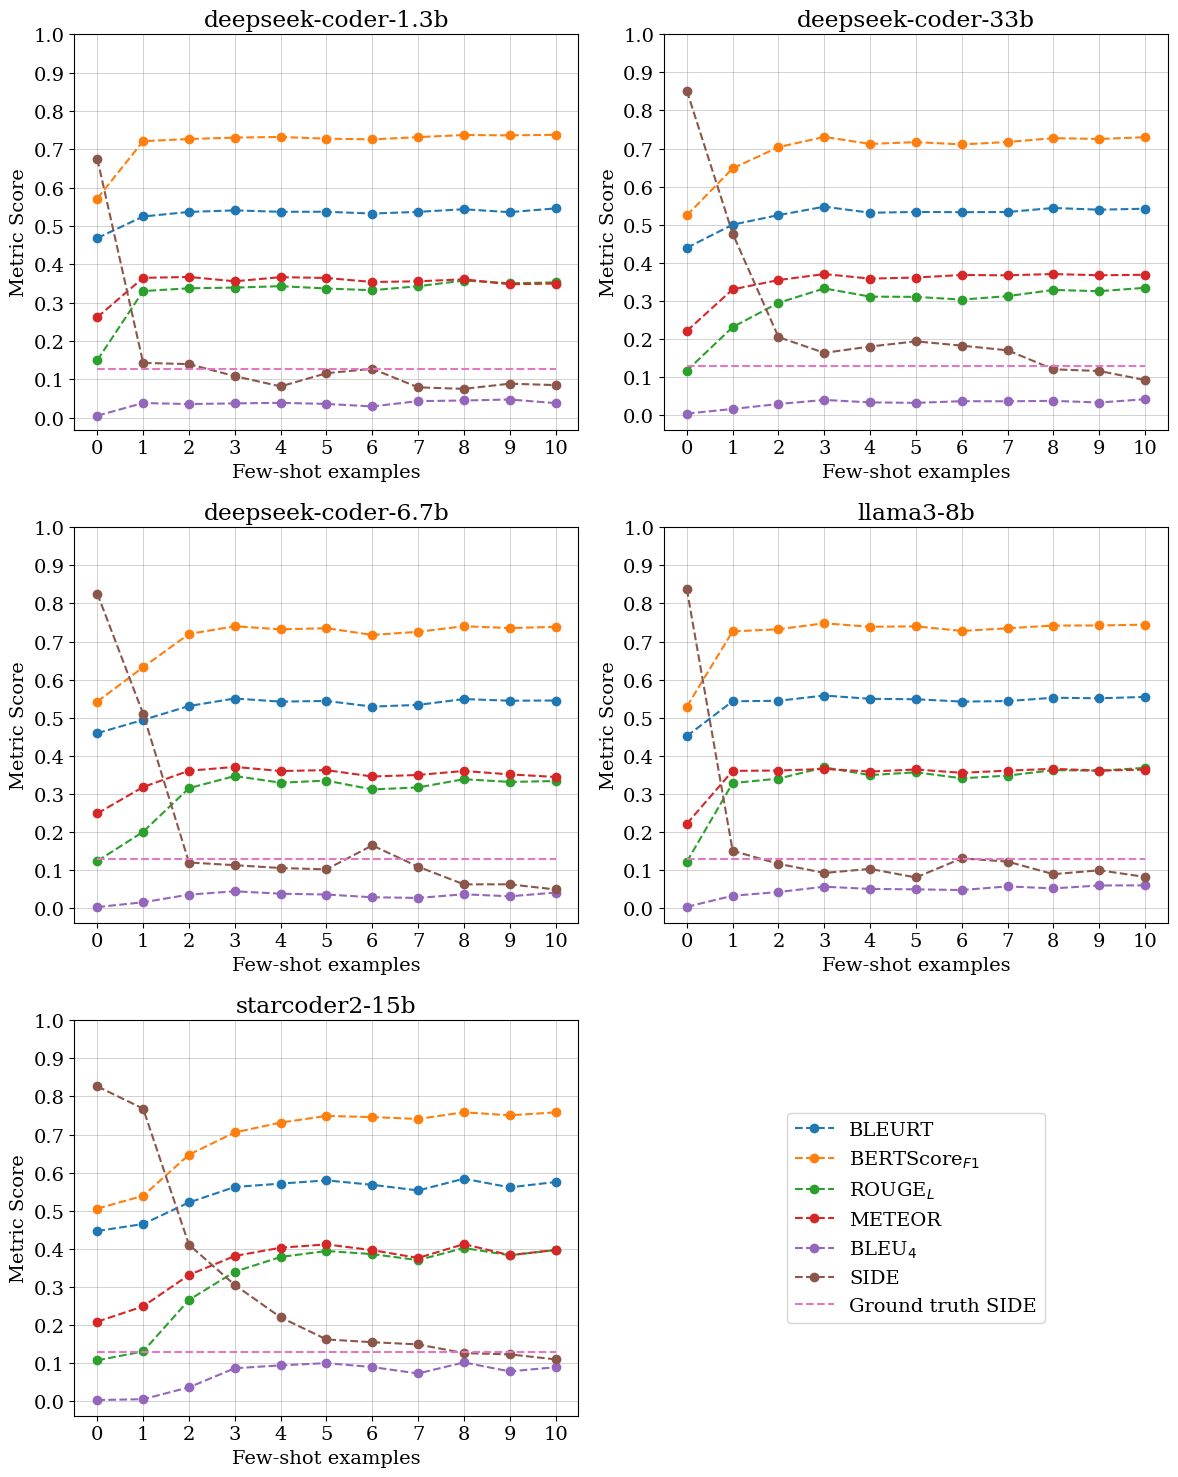

apache/airflow


open-mmlab/mmcv


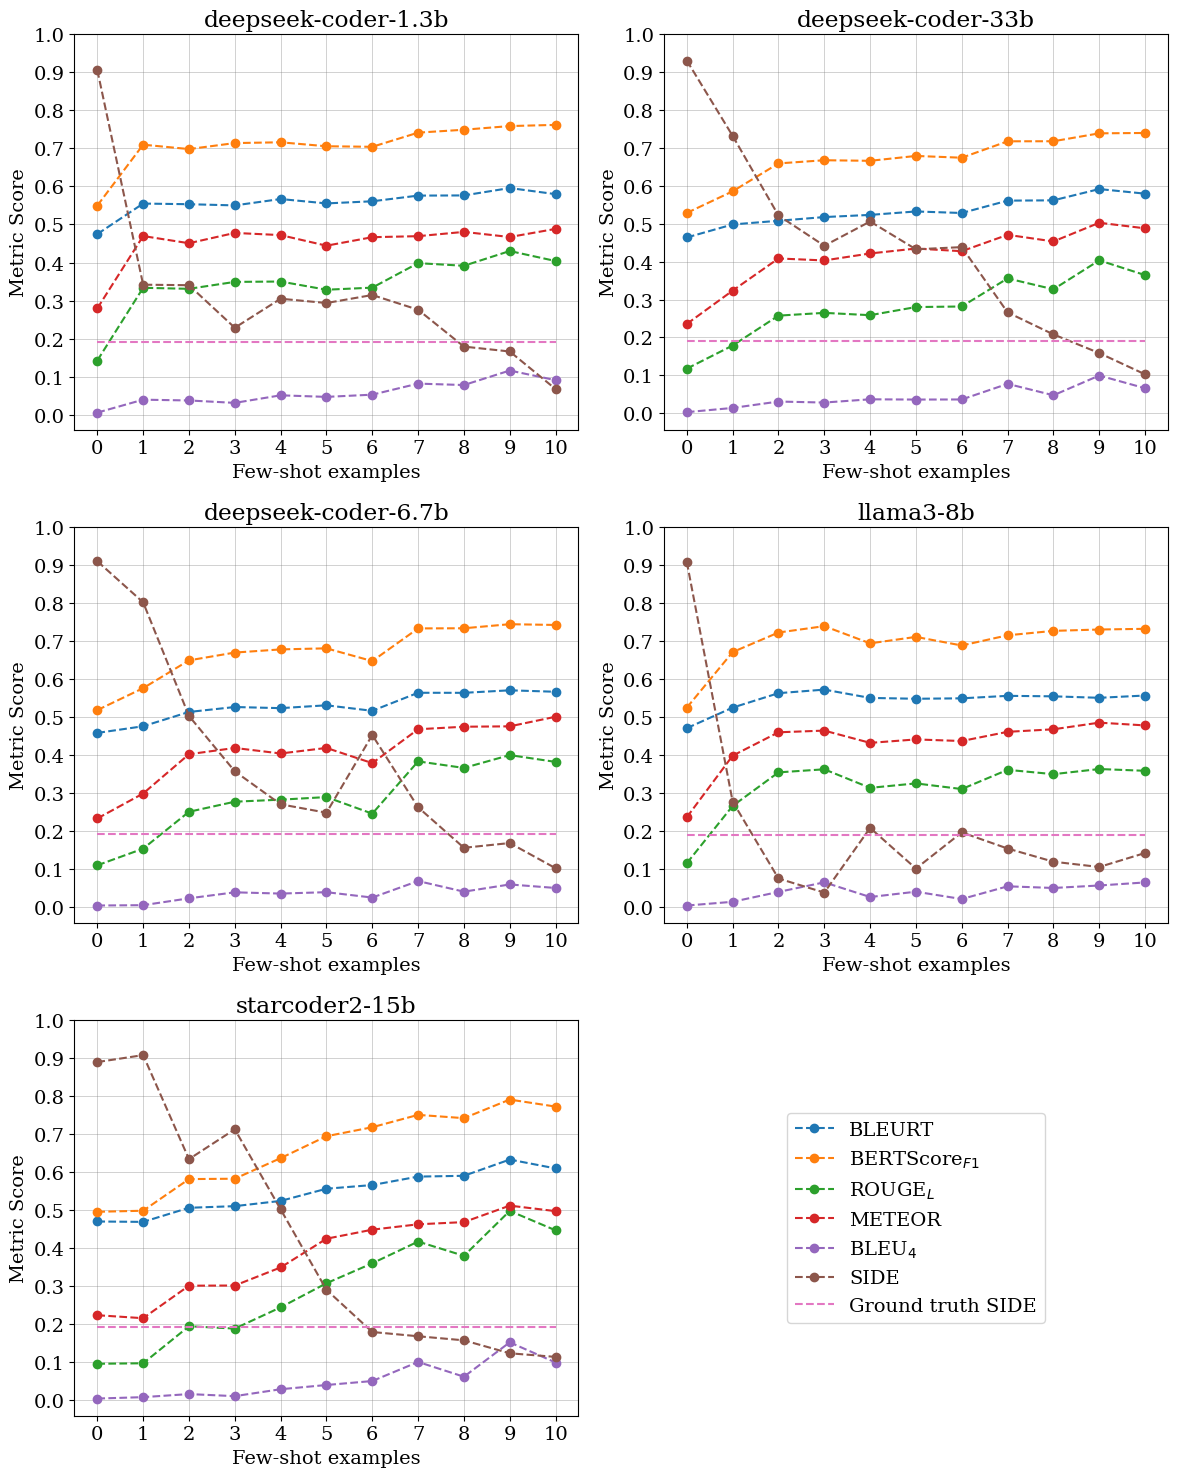

streamlink/streamlink


total


\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Function-level with few-shot Code Summarization Results on Modified CodeSearchNet}
\label{tab:results-func-lvl-mcsn-few-shot}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lccccccc}
\toprule
\textbf{Model} & \textbf{Few-shot} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule\multirow{4}{*}{deepseek-coder-1.3b} & 0 & 0.659 & 0.481 & 0.587 & 17.07 & 28.29 & 0.79\\
& 2 & 0.142 & 0.529 & 0.706 & 32.05 & 35.24 & 3.26\\
& 8 & 0.060 & 0.536 & 0.723 & 34.51 & 34.97 & 4.33\\
& 10 & 0.068 & 0.539 & 0.724 & 34.30 & 34.48 & 4.46\\
\midrule
\multirow{4}{*}{deepseek-coder-33b} & 0 & 0.829 & 0.455 & 0.535 & 12.66 & 22.75 & 0.34\\
& 2 & 0.250 & 0.523 & 0.686 & 28.27 & 34.36 & 2.71\\
& 8 & 0.098 & 0.541 & 0.713 & 31.53 & 35.63 & 3.46\\
& 10 & 0.074 & 0.543 & 0.718 & 32.83 & 36.41 & 4.14\\
\midrule
\multirow{4}{*

In [133]:
# All results for MCSN (Func-level with few-shot )
tdf = results_df[(results_df['Model'].isin(LLMs.values())) & (results_df['Context'].isnull()) & ~(results_df['Subset'].isin([None]))]
tdf = tdf.sort_values(by=['Model', 'Few-shot', SORT_BY], ascending=[True, True, True])

metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET
grouped = tdf.groupby('Subset')
for model, group in grouped:
    legend_elements = []
    subset_grouped = group.groupby('Model')
    num_models = len(grouped)
    num_cols = 2
    num_rows = num_models // num_cols + num_models % num_cols  # Integer division, rounding up
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs]
    for i, (subset, subset_group) in enumerate(subset_grouped):
        subset_group = subset_group.sort_values(by='Few-shot')
        ax = axs[i]
        for metric in metrics:
            plot= ax.plot(subset_group['Few-shot'], subset_group[metric], linestyle='--', marker='o')
            if i == num_models - 1:
                legend_elements.append(mlines.Line2D([0], [0], marker='o', color=plot[0].get_color(), linestyle='--', label=metric))
        plot = ax.plot(subset_group['Few-shot'], subset_group['SIDE_true'], label='Ground truth SIDE', linestyle='--')
        if i == num_models - 1:
            legend_elements.append(mlines.Line2D([0], [0], color=plot[0].get_color(), linestyle='--', label='Ground truth SIDE'))
        ax.set_xlabel('Few-shot examples')
        ax.set_ylabel('Metric Score')
        ax.set_xticks(range(0, 11, 1))
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
        ax.set_title(subset)
        ax.grid(True, color='gray', linewidth=0.5, alpha=0.5)
    for i in range(num_models, num_rows * num_cols):
        axs[i].axis('off')
        axs[i].legend(handles=legend_elements, loc='center')
    print(model)
    plt.tight_layout()
    plt.show()

tdf = tdf[tdf['Few-shot'].isin([0, 2, 8, 10]) & (tdf['Subset'] == "total")]
display(
    tdf.style.highlight_max(
        color="lightgreen", subset=MAX_METRICS_SUBSET
    ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
)
to_latex(tdf, label="results-func-lvl-mcsn-few-shot", caption="Function-level with few-shot Code Summarization Results on Modified CodeSearchNet")

In [12]:
def concat_few_shot_contexts(row):
    if row['Context'] is None:
        return str(row['Few-shot'])
    return f"{row['Few-shot']}+{row['Context'].split()[0]}"
def sort_key(x):
    parts = x.split('+')
    if len(parts) == 2:
        return int(parts[0]), int(parts[1])
    else:
        return int(parts[0]), 0

Azure/azure-sdk-for-python


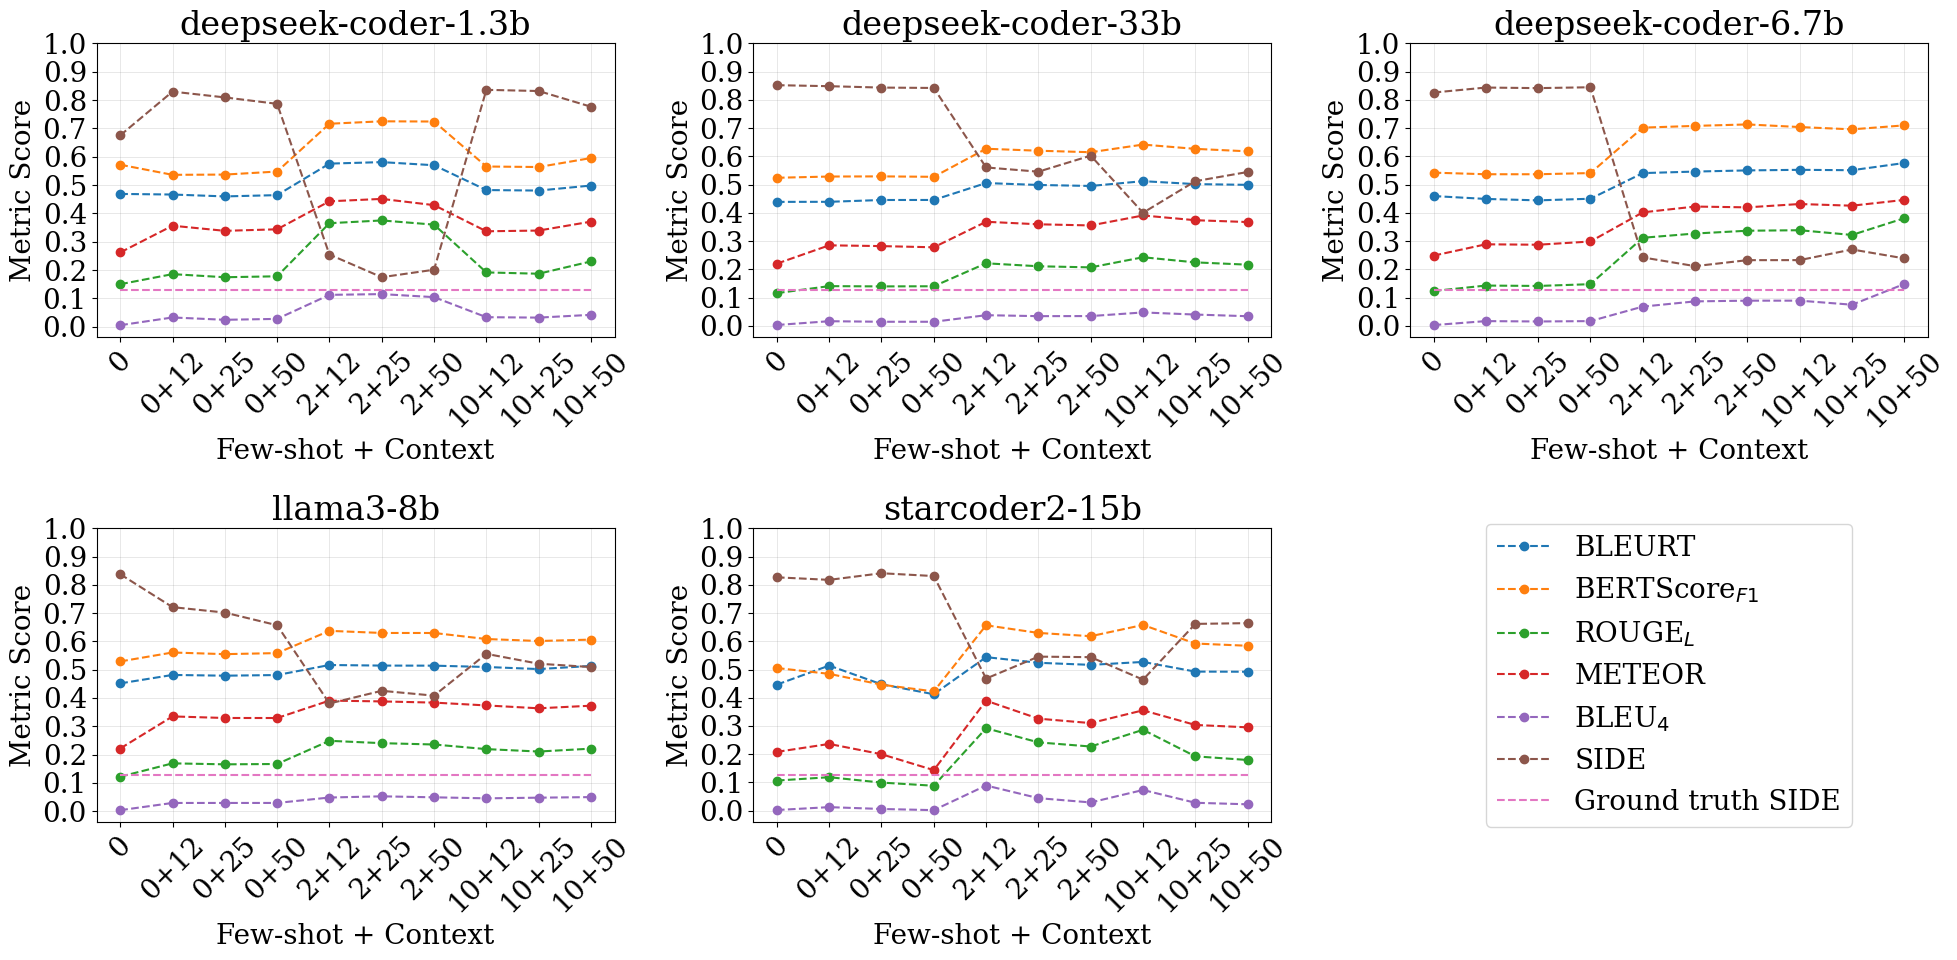

apache/airflow


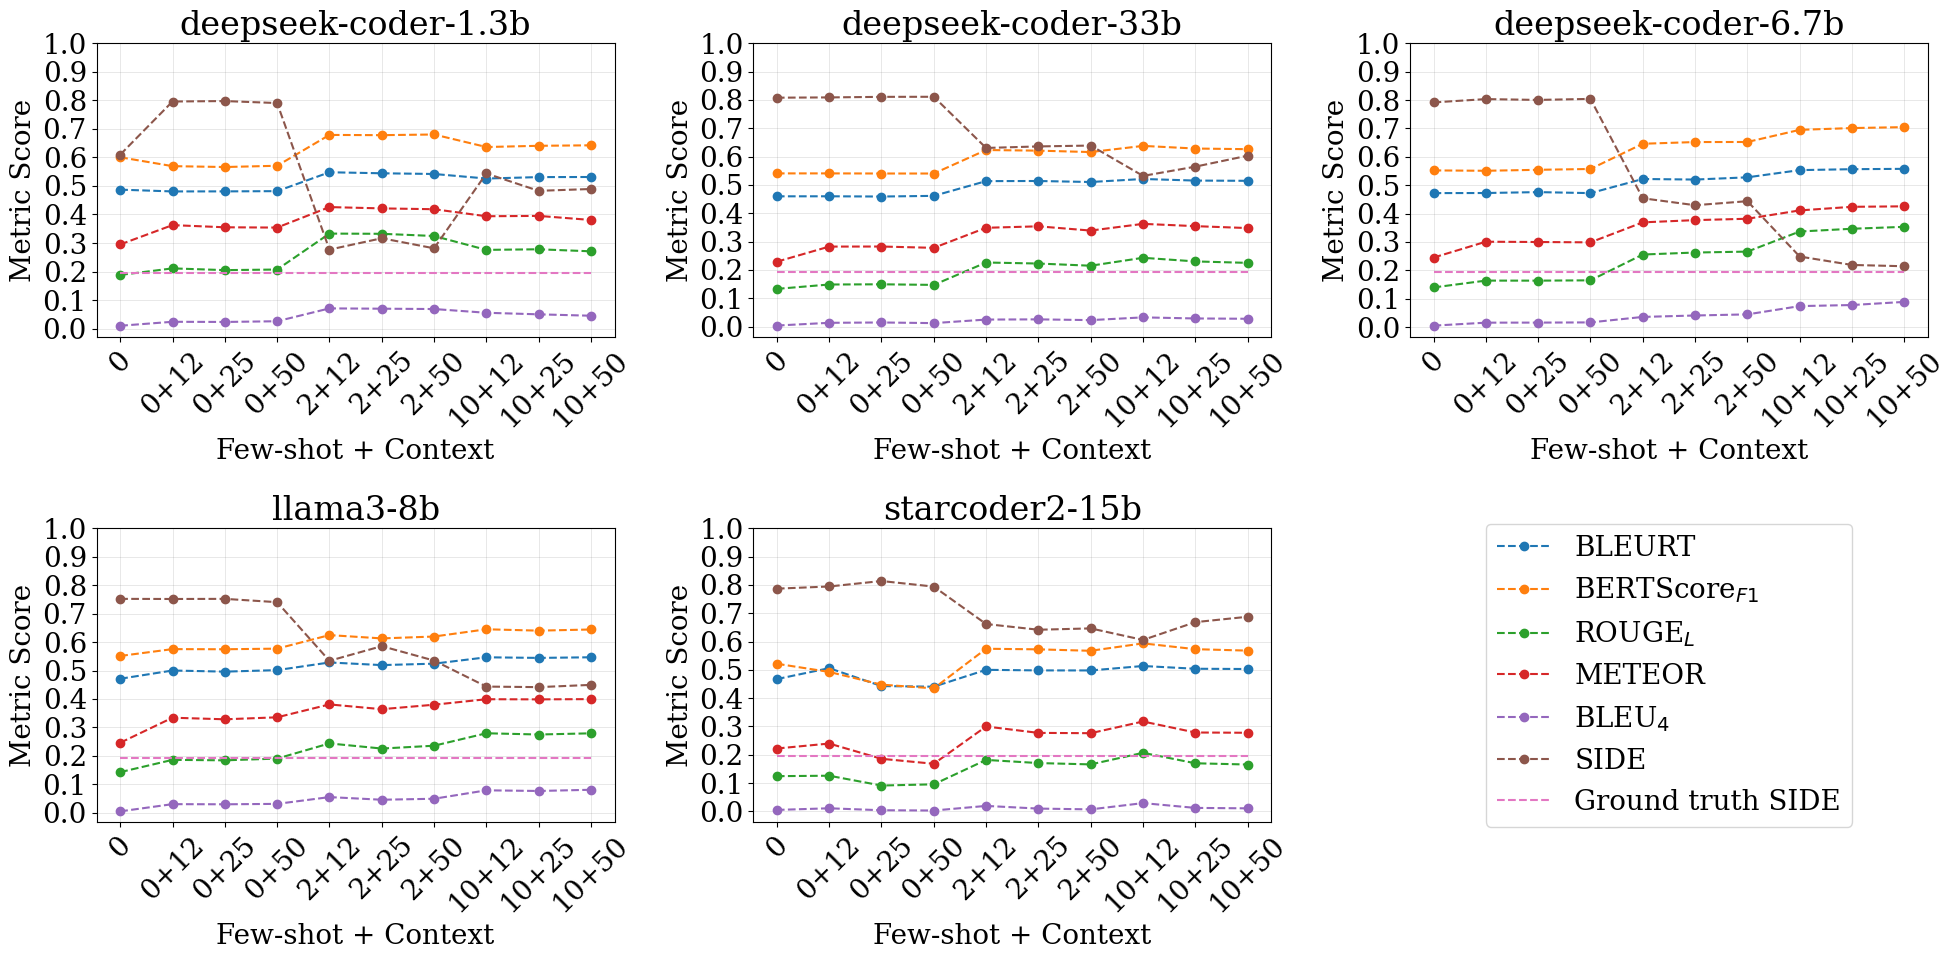

open-mmlab/mmcv


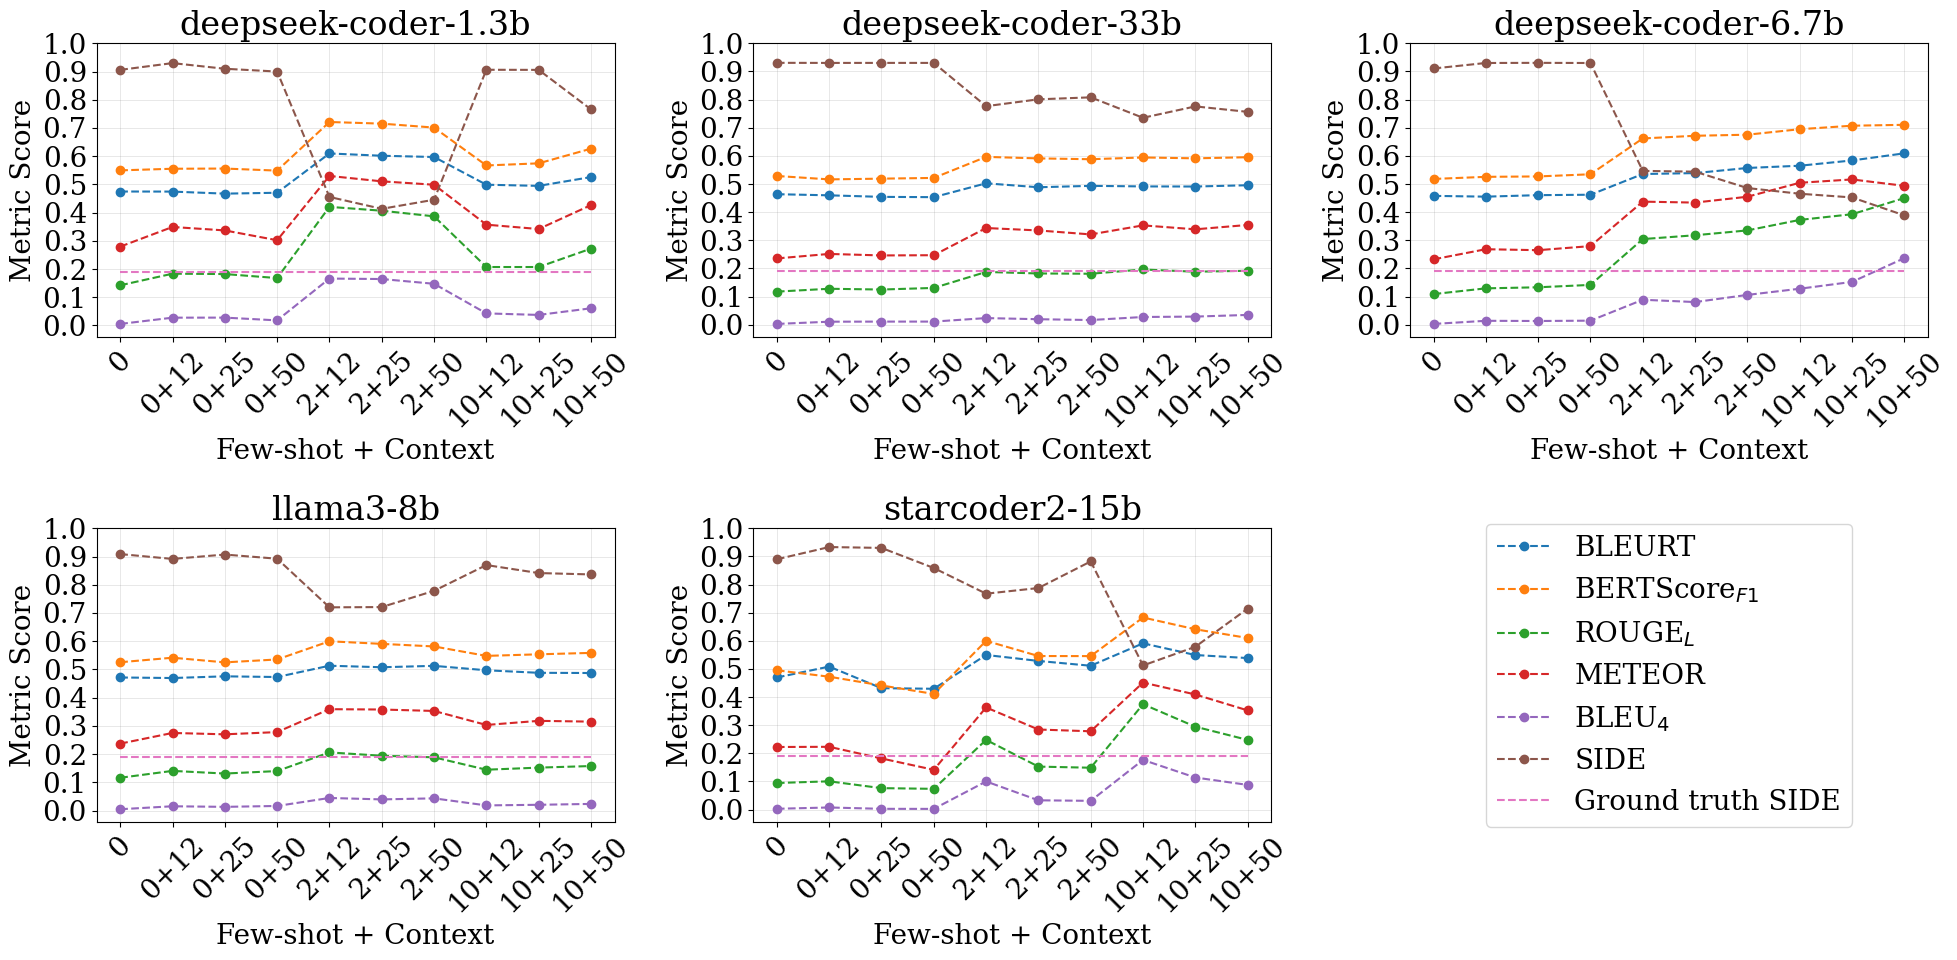

streamlink/streamlink


total


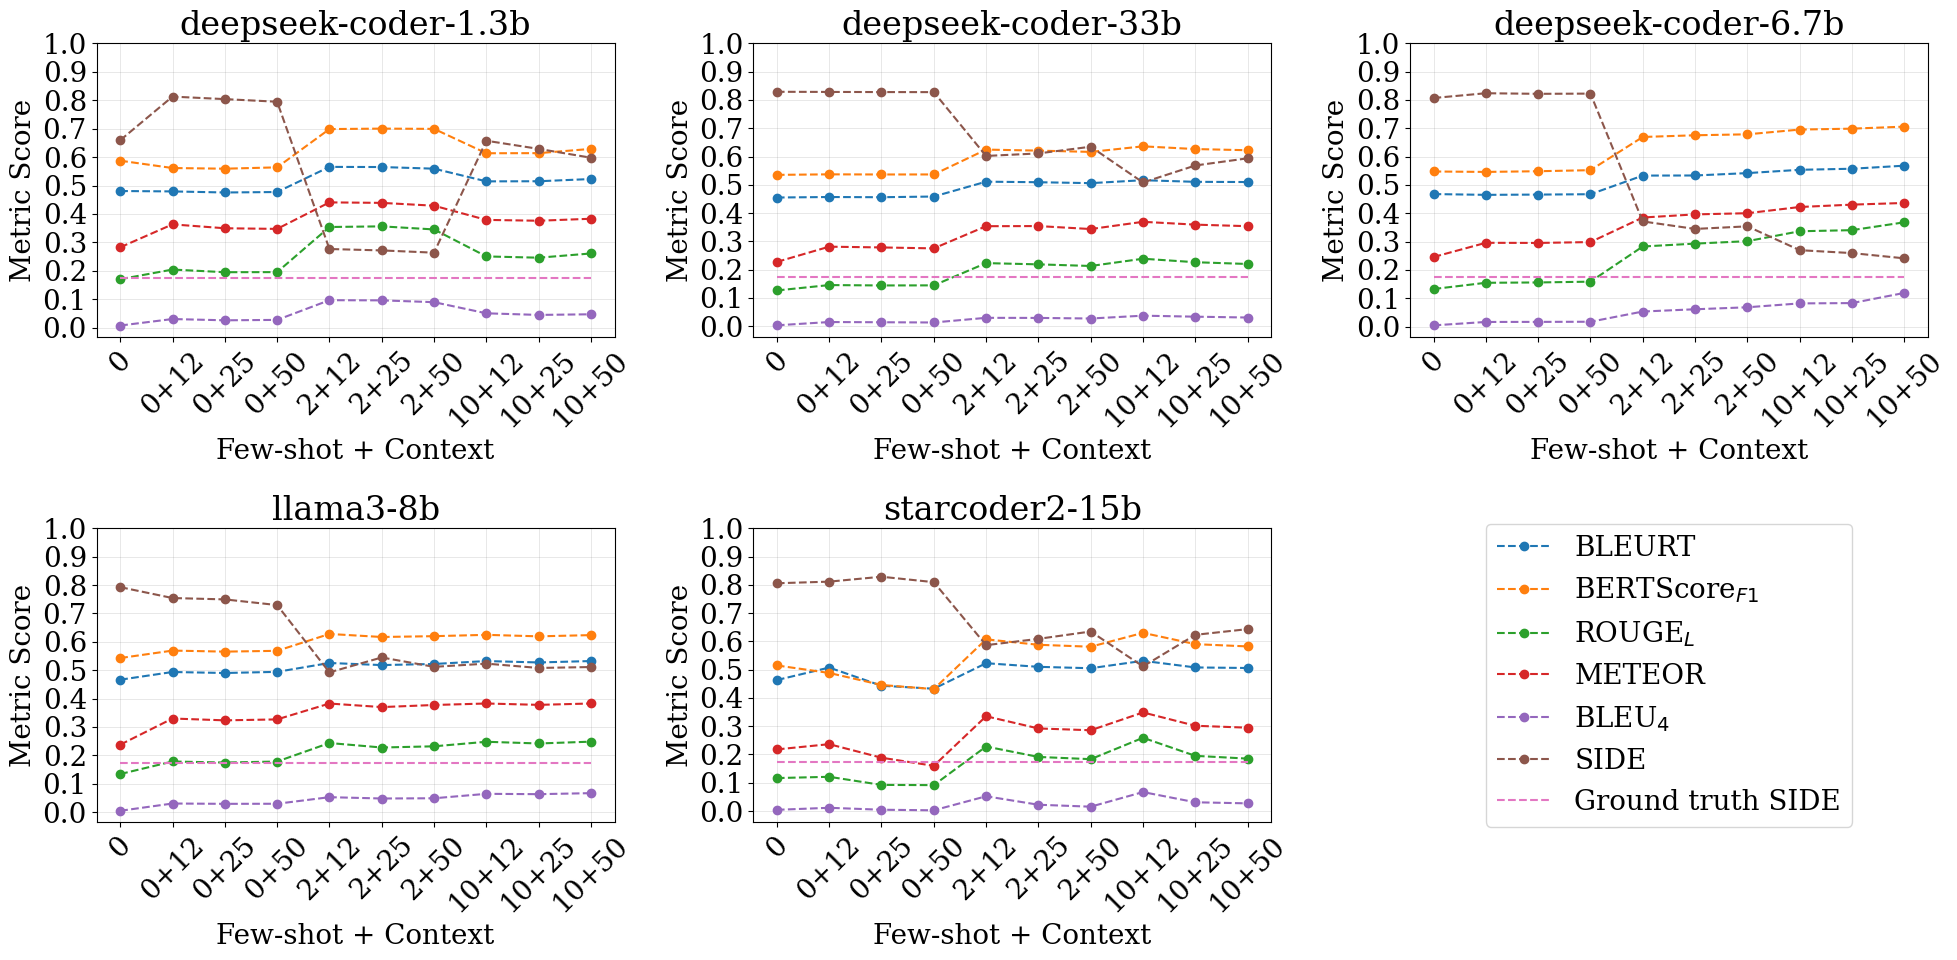

In [13]:
# All results for MCSN (Repo-level with few-shot and context)
tdf = results_df[
    (results_df['Model'].isin(LLMs.values())) & ~(results_df['Subset'].isin([None]))
    & ((~(results_df['Context'].isin(['skeleton', 'class', None])) & (results_df['Few-shot'].isin([0, 2, 10])))
    | ((results_df['Context'].isin([None])) & (results_df['Few-shot'].isin([0])) & ~(results_df['Subset'].isin([None]))))
    ]
tdf = tdf.sort_values(by=['Model', 'Few-shot', SORT_BY], ascending=[True, True, True])
tdf['Few-shot+Context'] = tdf.apply(lambda x: concat_few_shot_contexts(x), axis=1)
tdf['Sort'] = tdf['Few-shot+Context'].apply(sort_key)
x_values = sorted(list(tdf['Few-shot+Context'].unique()), key=sort_key)
metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET
grouped = tdf.groupby('Subset')
for model, group in grouped:
    legend_elements = []
    subset_grouped = group.groupby('Model')
    num_models = len(grouped)
    num_cols = 3
    num_rows = 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten() if num_rows > 1 else [axs]
    for i, (subset, subset_group) in enumerate(subset_grouped):
        subset_group = subset_group.sort_values(by='Sort')
        ax = axs[i]
        for metric in metrics:
            plot = ax.plot(x_values, subset_group[metric], linestyle='--', marker='o')
            if i == num_models - 1:
                legend_elements.append(mlines.Line2D([0], [0], marker='o', color=plot[0].get_color(), linestyle='--', label=metric))
        plot = ax.plot(x_values, subset_group['SIDE_true'], label='Ground truth SIDE', linestyle='--')
        if i == num_models - 1:
            legend_elements.append(mlines.Line2D([0], [0], color=plot[0].get_color(), linestyle='--', label='Ground truth SIDE'))
        ax.set_xlabel('Few-shot + Context')
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylabel('Metric Score')
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
        ax.set_title(subset)
        ax.grid(True, color='gray', linewidth=0.5, alpha=0.25)
    for i in range(num_models, num_rows * num_cols):
        axs[i].axis('off')
        axs[i].legend(handles=legend_elements, loc='center')
    print(model)
    plt.tight_layout()
    plt.show()

Azure/azure-sdk-for-python


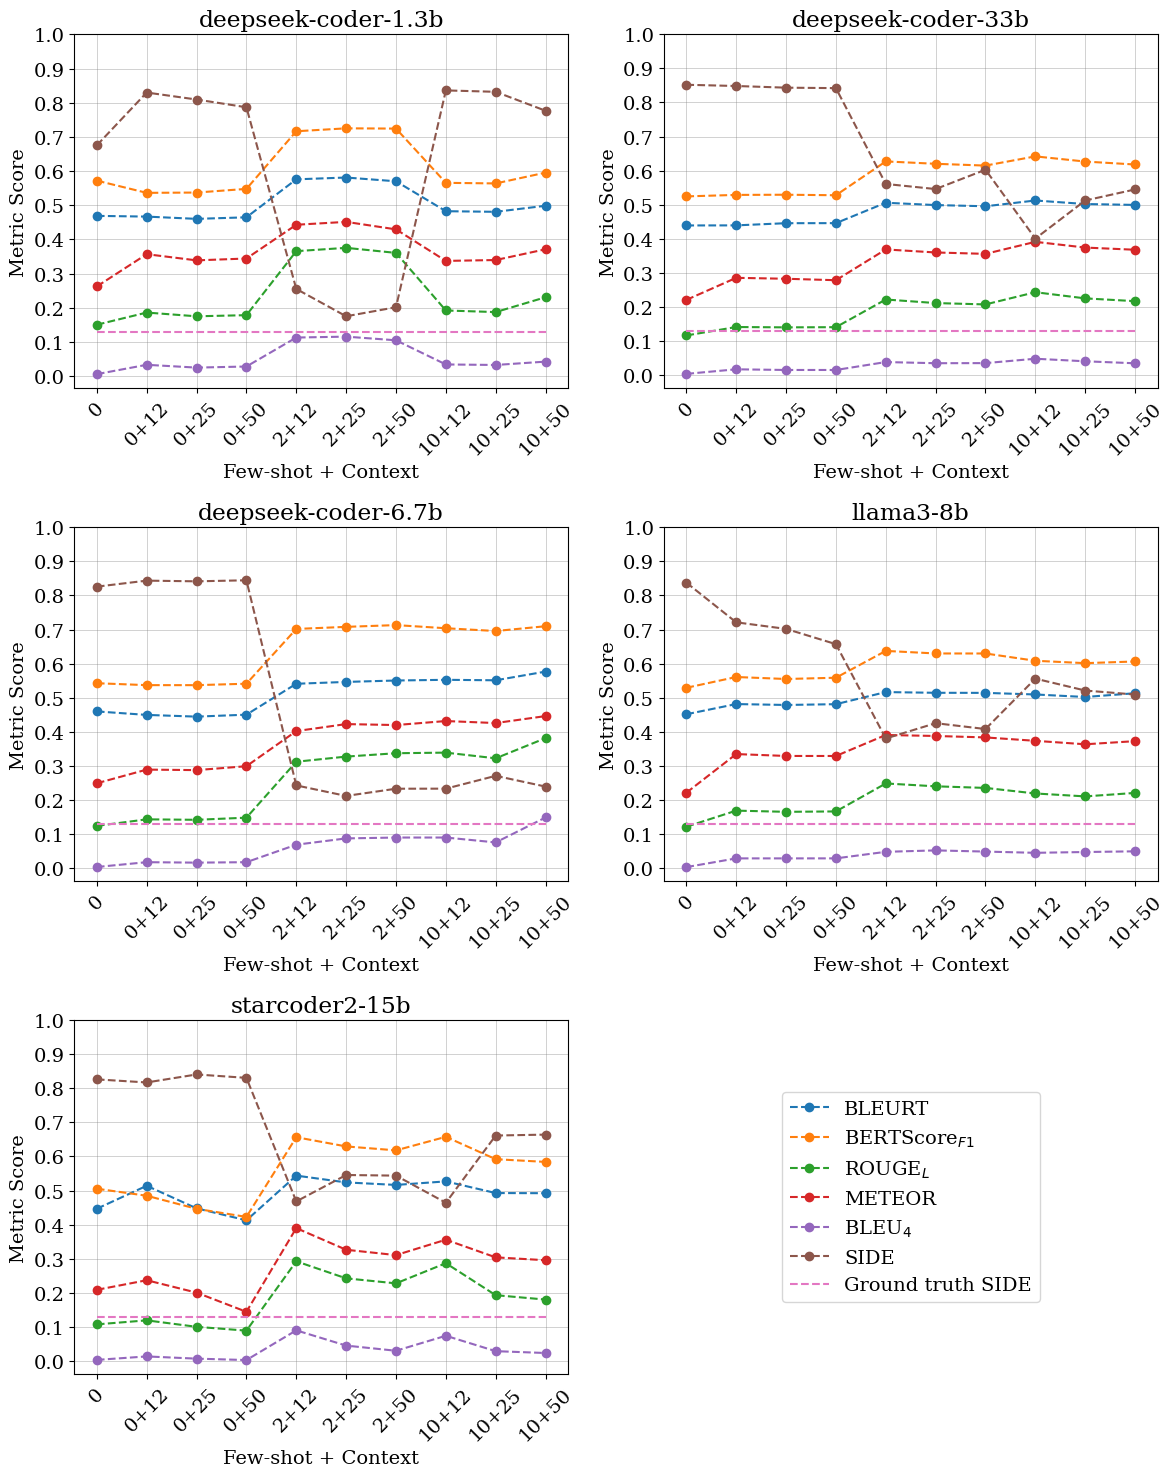

apache/airflow


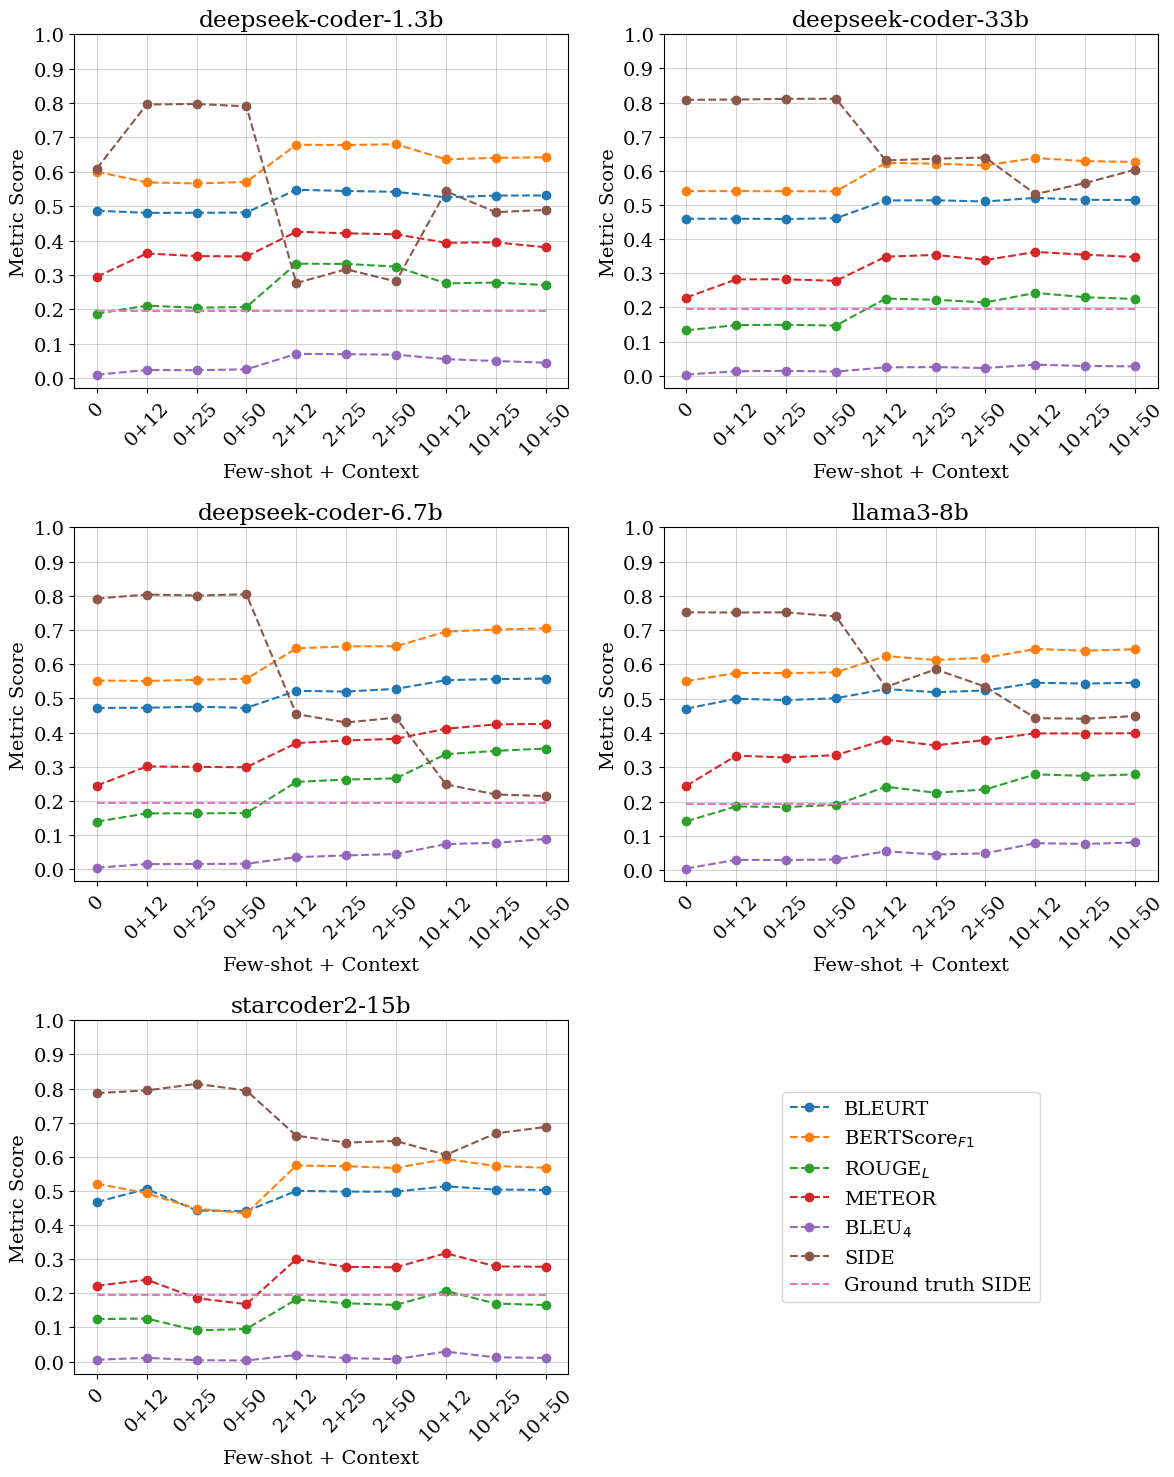

open-mmlab/mmcv


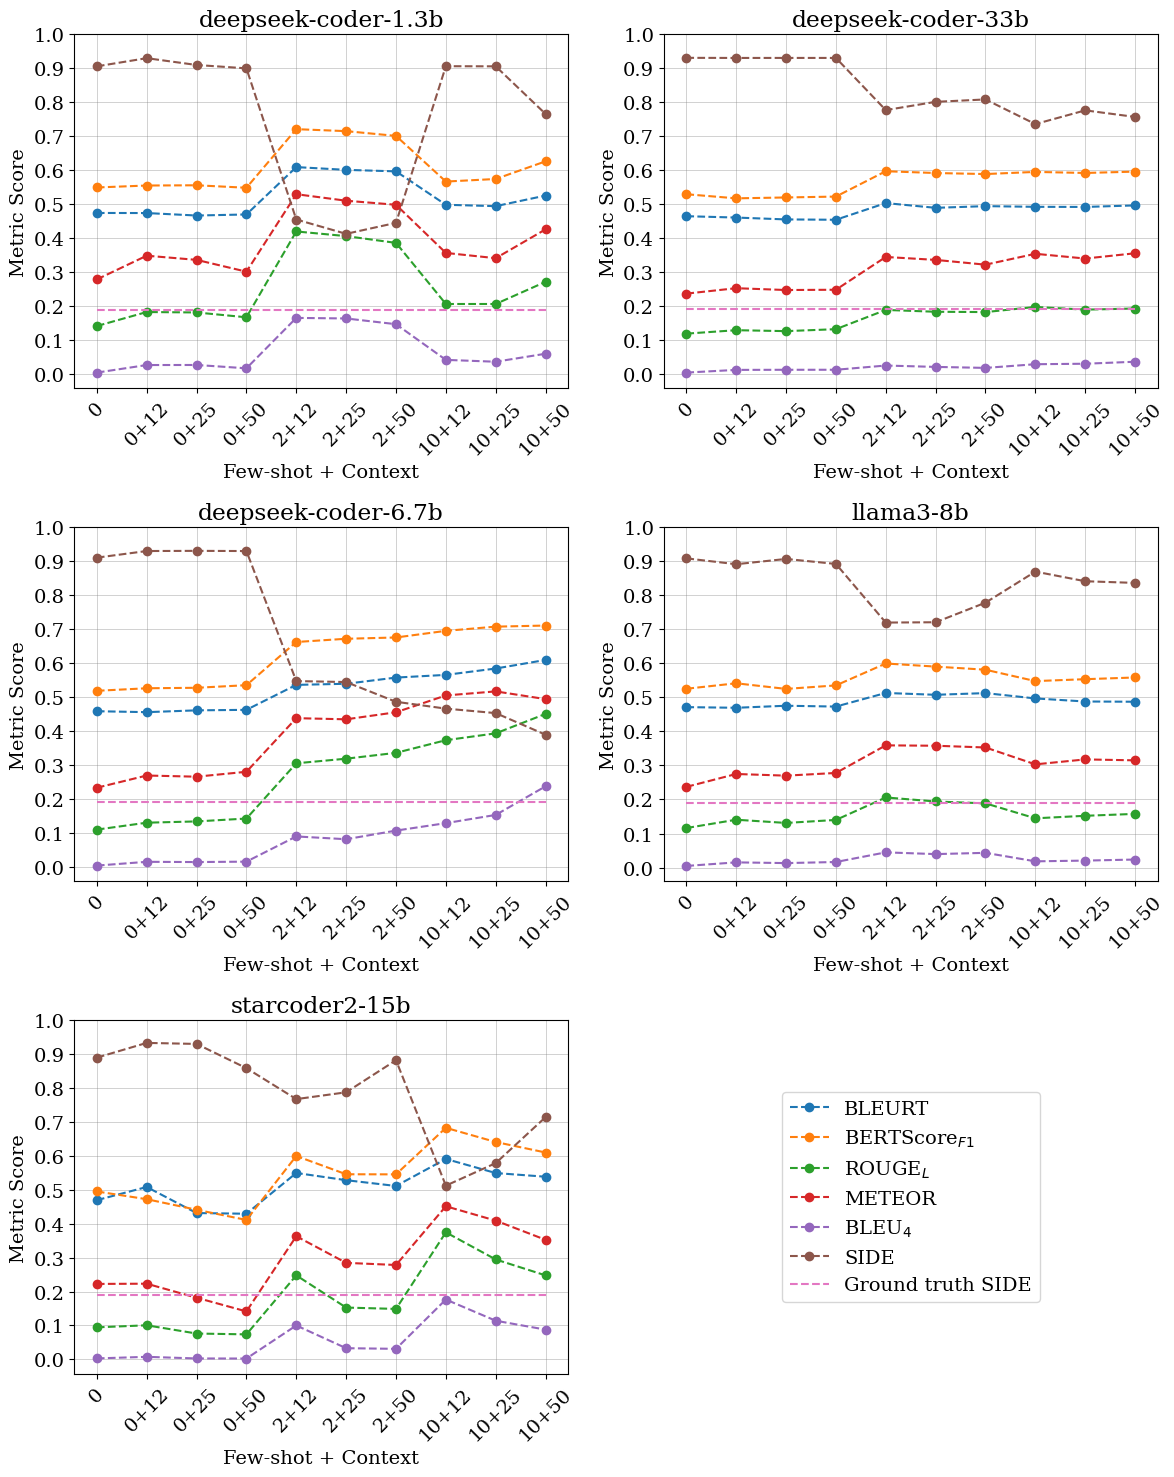

streamlink/streamlink


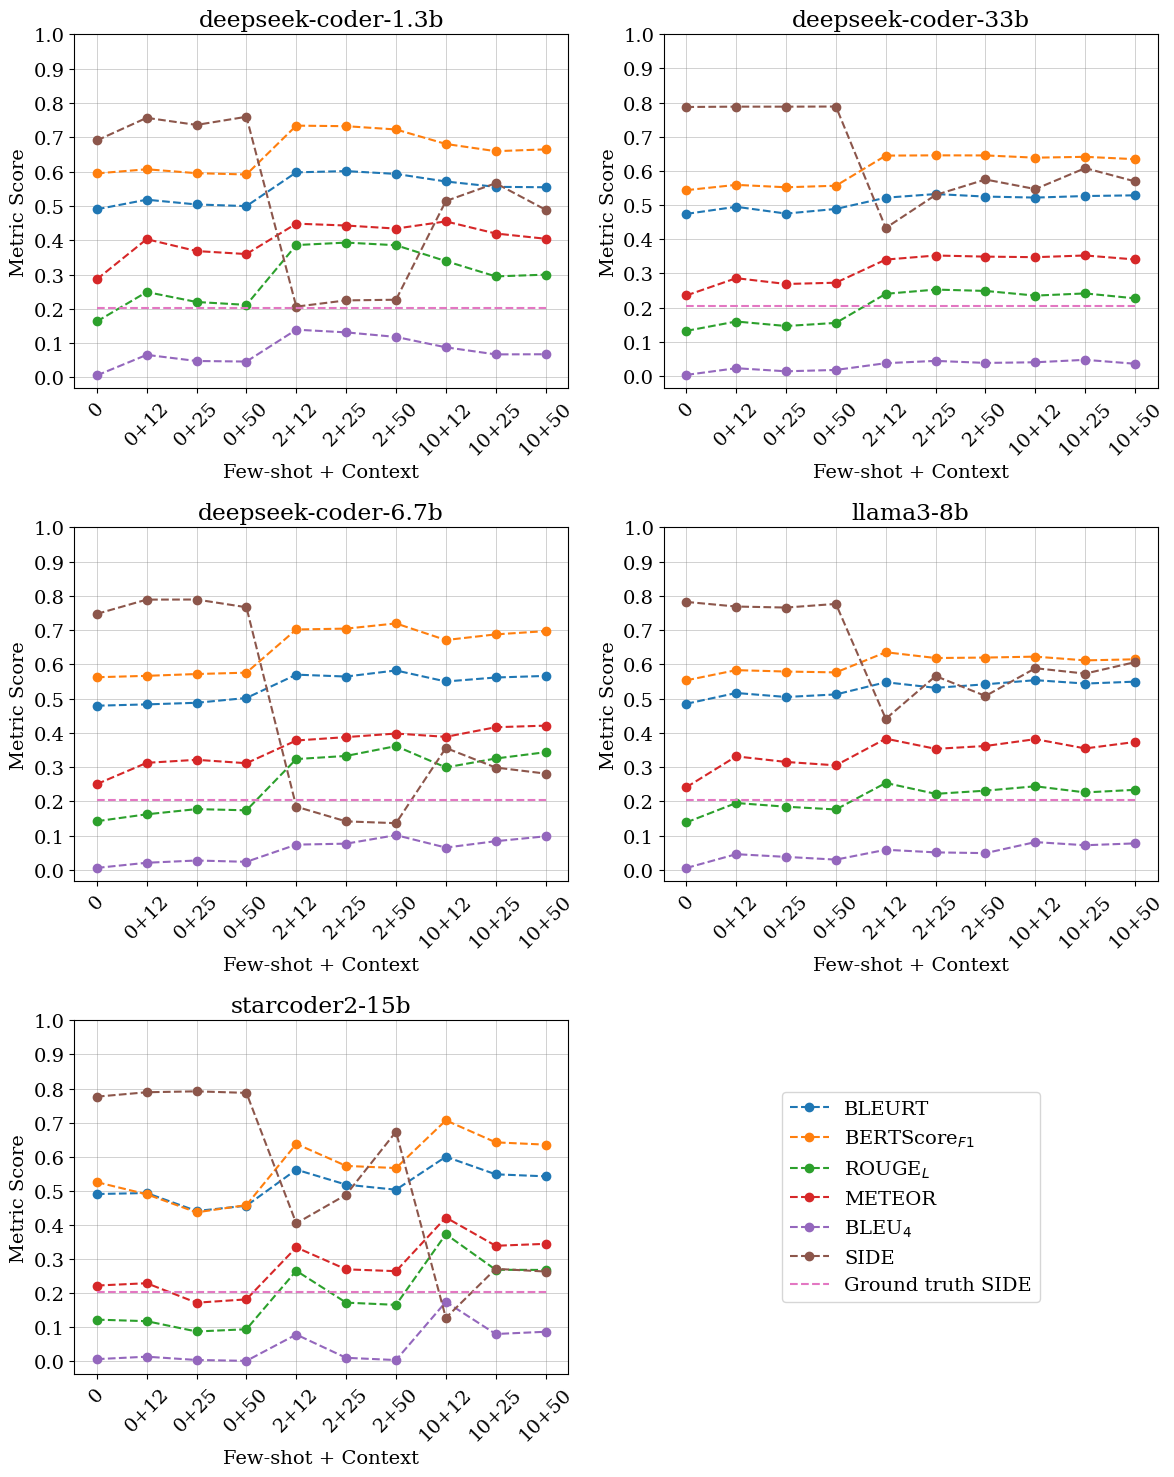

total


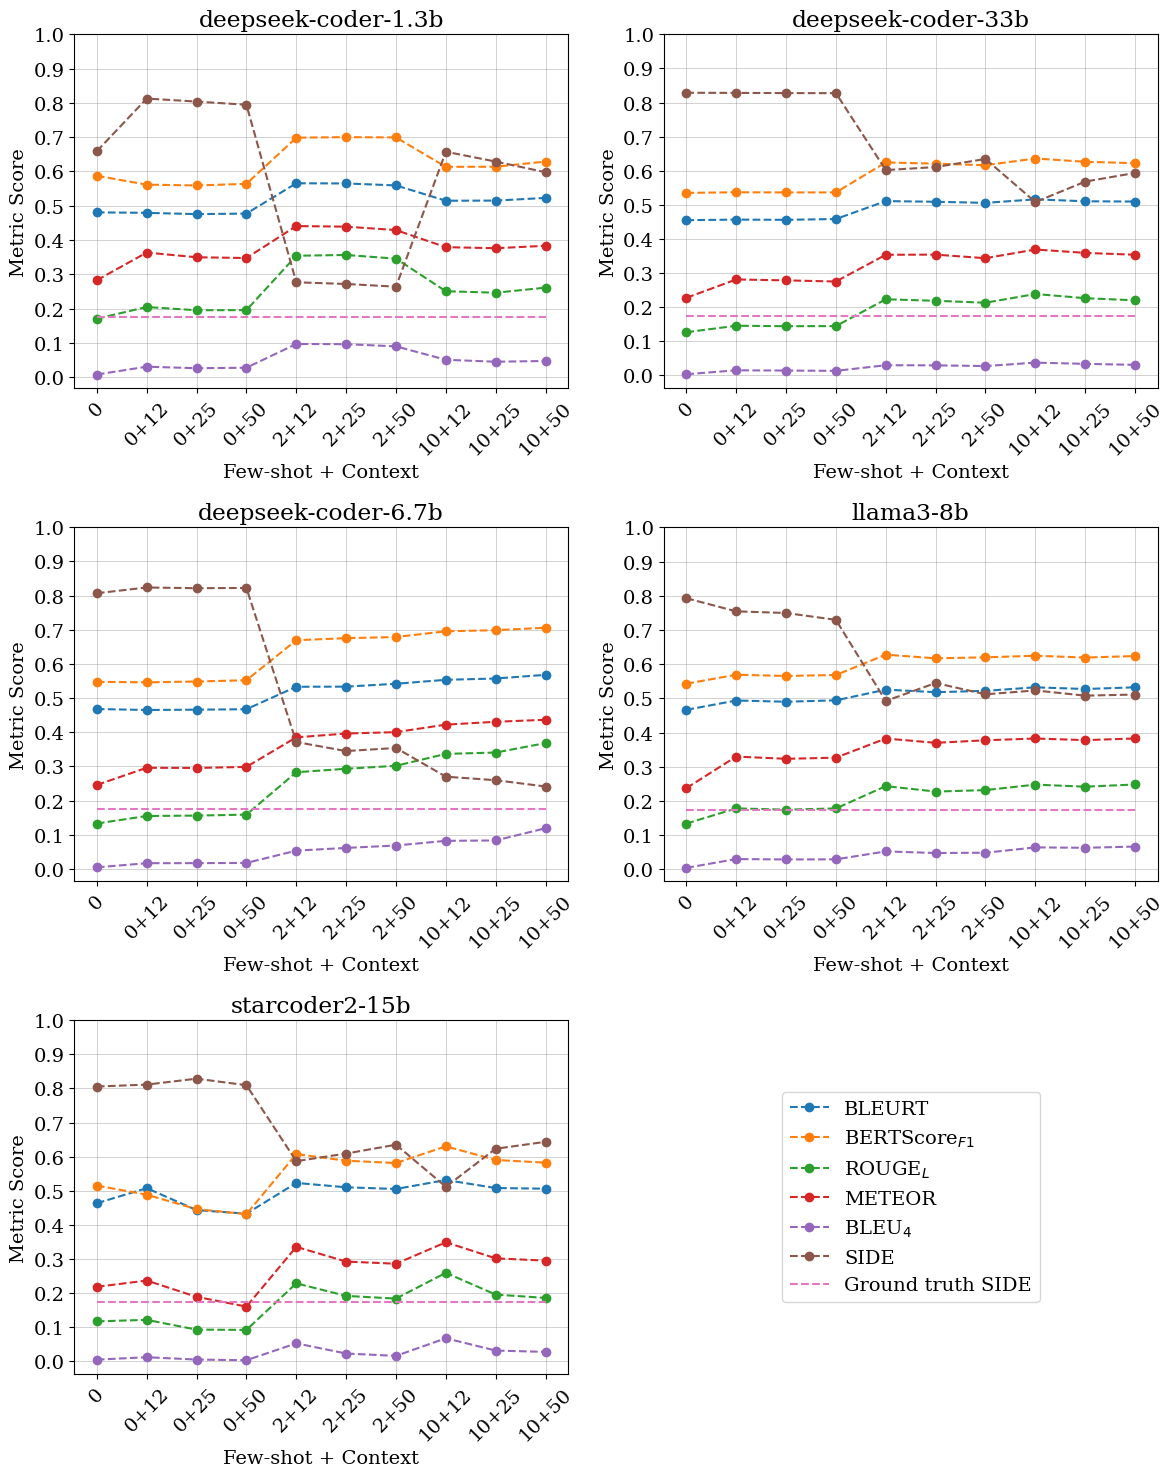

In [73]:
# All results for MCSN (Repo-level with few-shot and context)
tdf = results_df[
    (results_df['Model'].isin(LLMs.values())) & ~(results_df['Subset'].isin([None]))
    & ((~(results_df['Context'].isin(['skeleton', 'class', None])) & (results_df['Few-shot'].isin([0, 2, 10])))
    | ((results_df['Context'].isin([None])) & (results_df['Few-shot'].isin([0])) & ~(results_df['Subset'].isin([None]))))
    ]
tdf = tdf.sort_values(by=['Model', 'Few-shot', SORT_BY], ascending=[True, True, True])
tdf['Few-shot+Context'] = tdf.apply(lambda x: concat_few_shot_contexts(x), axis=1)
tdf['Sort'] = tdf['Few-shot+Context'].apply(sort_key)
x_values = sorted(list(tdf['Few-shot+Context'].unique()), key=sort_key)
metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET
grouped = tdf.groupby('Subset')
for model, group in grouped:
    legend_elements = []
    subset_grouped = group.groupby('Model')
    num_models = len(grouped)
    num_cols = 2
    num_rows = num_models // num_cols + num_models % num_cols  # Integer division, rounding up
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs]
    for i, (subset, subset_group) in enumerate(subset_grouped):
        subset_group = subset_group.sort_values(by='Sort')
        ax = axs[i]
        for metric in metrics:
            plot = ax.plot(x_values, subset_group[metric], linestyle='--', marker='o')
            if i == num_models - 1:
                legend_elements.append(mlines.Line2D([0], [0], marker='o', color=plot[0].get_color(), linestyle='--', label=metric))
        plot = ax.plot(x_values, subset_group['SIDE_true'], label='Ground truth SIDE', linestyle='--')
        if i == num_models - 1:
            legend_elements.append(mlines.Line2D([0], [0], color=plot[0].get_color(), linestyle='--', label='Ground truth SIDE'))
        ax.set_xlabel('Few-shot + Context')
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylabel('Metric Score')
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
        ax.set_title(subset)
        ax.grid(True, color='gray', linewidth=0.5, alpha=0.5)
    for i in range(num_models, num_rows * num_cols):
        axs[i].axis('off')
        axs[i].legend(handles=legend_elements, loc='center')
    print(model)
    plt.tight_layout()
    plt.show()

# tdf = tdf[tdf['Few-shot'].isin([0, 2, 8, 10]) & (tdf['Subset'] == "total")]
# display(
#     tdf.style.highlight_max(
#         color="lightgreen", subset=MAX_METRICS_SUBSET
#     ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
# )
# to_latex(tdf, label="results-func-lvl-mcsn-few-shot", caption="Function-level with few-shot Code Summarization Results on Modified CodeSearchNet")

In [23]:
# All results for MCSN (Repo-level with few-shot and context)
tdf = results_df[~(results_df['Context'].isin(['skeleton', 'class', None])) & (results_df['Subset'].isin(["total"])) & (results_df['Few-shot'].isin([0, 2, 10]))]
tdf = tdf.sort_values(by=['Model', 'Context', SORT_BY], ascending=[True, True, True])

metrics = MAX_METRICS_SUBSET + MIN_METRICS_SUBSET

grouped = tdf.groupby(['Model'])

# tdf = tdf[tdf['Few-shot'].isin([0, 2, 8, 10])]
display(
    tdf.style.highlight_max(
        color="lightgreen", subset=MAX_METRICS_SUBSET
    ).highlight_min(color="lightgreen", subset=MIN_METRICS_SUBSET)
)
to_latex(tdf, label="results-repo-lvl-mcsn-few-shot", caption="Repo-level with few-shot Code Summarization Results on Modified CodeSearchNet")

\begin{table}[h]
\centering\captionsetup{justification=centering}
\caption{Repo-level with few-shot Code Summarization Results on Modified CodeSearchNet}
\label{tab:results-repo-lvl-mcsn-few-shot}
\begin{threeparttable}[b]
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccccc}
\toprule
\textbf{Model} & \textbf{Few-shot} & \textbf{Context} & \textbf{SIDE\tnote{1}} & \textbf{BLEURT} & \textbf{BERTScore$_{F1}$} & \textbf{ROUGE$_{L}$} & \textbf{METEOR} & \textbf{BLEU$_{4}$} \\
\midrule\multirow{3}{*}{deepseek-coder-1.3b} & 2 & 12 chunks & 0.277 & 0.566 & 0.699 & 0.354 & \textbf{0.441} & 0.097\\
& 10 & 12 chunks & 0.658 & 0.515 & 0.614 & 0.251 & 0.379 & 0.051\\
& 0 & 12 chunks & 0.813 & 0.479 & 0.562 & 0.205 & 0.364 & 0.031\\
\midrule
\multirow{3}{*}{deepseek-coder-1.3b} & 2 & 25 chunks & 0.272 & 0.565 & 0.700 & 0.357 & 0.439 & 0.096\\
& 10 & 25 chunks & 0.629 & 0.515 & 0.614 & 0.246 & 0.376 & 0.045\\
& 0 & 25 chunks & 0.804 & 0.476 & 0.559 & 0.195 & 0.350 & 0.026\\
\midrule
\multirow{3}{*}{